# Project color transfert from Reinhard et al [2001]. 

Objective: Implement a color transfer algorithm according to the article by Reinhard et al. [2001].<br>
This requires going through a method of converting an RGB space into LAB and performing a statistical calculation (mean and standard deviation) to generate an output image with transferred colors.<br>
The research paper gives details of which matrices to use to convert to LAB, I used a classic method to convert sRGB D65 images to XYZ then LAB color space, and the results given at the end of this notebook seem to match the expected results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

In [2]:
# Set of utilitary functions for this notebook.

def read_file(srcFilename, tarFilename):
    img_src = imageio.imread(srcFilename)
    img_tar = imageio.imread(tarFilename)
    
    return img_src, img_tar


def show_imgs(data_src, datat_tar, data_out=None):
    nbCols = 2

    if(data_out is not None):
        nbCols = 3

    fig, axes = plt.subplots(ncols=nbCols, figsize=(15, 5))
    ax = axes.ravel()
    ax[0] = plt.subplot(1, nbCols, 1)
    ax[1] = plt.subplot(1, nbCols, 2)
    
    ax[0].imshow(data_src)
    ax[0].set_title('Source image')
    ax[0].axis('off')

    ax[1].imshow(datat_tar)
    ax[1].set_title('Target image')
    ax[1].axis('off')

    if(data_out is not None):
        ax[2] = plt.subplot(1, nbCols, 3)
        ax[2].imshow(data_out)
        ax[2].set_title('Output image')
        ax[2].axis('off')
    
    plt.show()

Here we see that *the source image* corresponds to the modified target image in output, and *the target image* corresponds to the reference image used to perform the color transfer on the target image.

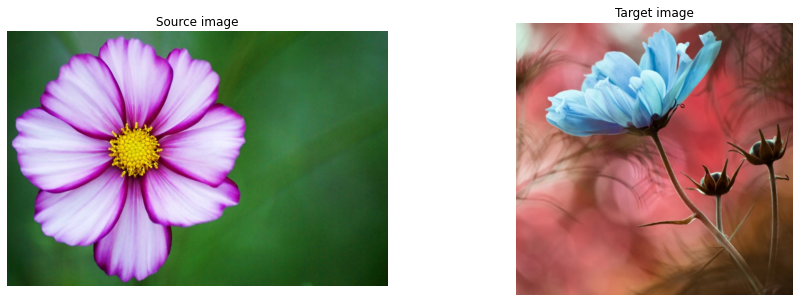

In [3]:
data_src, data_tar = read_file('ressources/img_input/0_in.jpg', 'ressources/img_ref/0_ref.jpg')
show_imgs(data_src, data_tar)

Here, we fully implements the RGB to LAB conversion using the reference white color D65 with sRGB space color, used in most screen.

In [4]:
# Complete redefining conversion RGB --> XYZ --> LAB and vice versa

# White référence (D65)
XYZ_White_D65 = np.array([0.95047, 1.0, 1.08883], dtype=np.float64)

# Conversion matrix linear RGB --> XYZ
mat_RGBtoXYZ = np.array([[0.4124564, 0.3575761, 0.1804375],
                         [0.2126729, 0.7151522, 0.0721750],
                         [0.0193339, 0.1191920, 0.9503041]], dtype=np.float64)

# Reverse conversion matrix XYZ --> linear RGB
mat_XYZtoRGB = np.linalg.inv(mat_RGBtoXYZ)

# Use of two constants, k and ep given by the CIE 1931 color space standard to compute the LAB conversion
ep = 0.008856
k = 903.3

# ---------------------------------------------------------------------------------------------

# ENCODING AND DECONDING FUNCTION FOR THE GAMMA


def decode_gamma(RGB):
    if RGB <= 0.04045:
        return RGB / 12.92
    
    return np.power((RGB + 0.055) / 1.055, 2.4)


def encode_gamma(rgb):
    if rgb <= 0.0031308:
        return 12.92 * rgb
    
    return 1.055 * np.power(rgb, 1 / 2.4) - 0.055


# ---------------------------------------------------------------------------------------------


# Various function used for converting to LAB and vice versa
def f(val):
    if val > ep:
        return val ** (1.0/3.0)
    
    return (k * val + 16.0) / 116.0

def g_x(L, a):
    return a / 500.0 + g_y(L)

def g_z(L, b):
    return g_y(L) - (b / 200.0)

def g_y(L):
    return (L + 16.0) / 116.0

def g_xzr(L, a_b, g):
    val = g(L, a_b)
    g3 = val ** (3.0)
    if g3 > ep:
        return g3
    
    return (116.0 * val - 16.0) / k

def g_yr(L):
    if L > (k * ep):
        return ((L + 16.0) / 116.0) ** (3.0)
    
    return L / k


# ---------------------------------------------------------------------------------------------

# Main functions of conversion RGB2LAB & LAB2RGB

# Function allowing to convert an RGB image (sRGB D65) to the LAB color space
def RGB2LAB(data):
    h, w, _ = data.shape
    data_LAB = np.zeros(data.shape, dtype=np.float64)
    data_cpy = np.copy(data).astype(np.float64)
    
    # We normalize the image between 0.0 and 1.0
    data_cpy /= 255.

    for j in range(h):
        for i in range(w):
            # RGB --> linear RGB (deletion of gamma correction)
            r = decode_gamma(data_cpy[j, i, 0])
            g = decode_gamma(data_cpy[j, i, 1])
            b = decode_gamma(data_cpy[j, i, 2])
            
            # linear RGB --> XYZ
            XYZ = np.matmul(mat_RGBtoXYZ, [r, g, b])
            fx = f(XYZ[0] / XYZ_White_D65[0])
            fy = f(XYZ[1] / XYZ_White_D65[1])
            fz = f(XYZ[2] / XYZ_White_D65[2])
            
            # XYZ --> LAB
            data_LAB[j, i, 0] = 116.0 * fy - 16.0
            data_LAB[j, i, 1] = 500.0 * (fx - fy)
            data_LAB[j, i, 2] = 200.0 * (fy - fz)
    
    return data_LAB


# Function allowing to convert a data in LAB space color to RGB color space (sRGB D65)
def LAB2RGB(data):
    h, w, _ = data.shape
    data_RGB = np.zeros(data.shape, dtype=np.float64)
    
    for j in range(h):
        for i in range(w):
            # LAB --> XYZ
            L, a, b = data[j, i]
            x = g_xzr(L, a, g_x) * XYZ_White_D65[0]
            y = g_yr(L) * XYZ_White_D65[1]
            z = g_xzr(L, b, g_z) * XYZ_White_D65[2]
            XYZ = np.array([x, y, z])
            
            # XYZ --> RGB Linéaire
            R, G, B = np.matmul(mat_XYZtoRGB, XYZ)
            
            # Linear RGB --> RGB and Reapply gamma correction
            data_RGB[j, i, 0] = encode_gamma(R)
            data_RGB[j, i, 1] = encode_gamma(G)
            data_RGB[j, i, 2] = encode_gamma(B)
    
    # We clamp the current image sRGB between 0. and 1. then, rescale between 0 et 255 
    data_RGB = np.clip(data_RGB, 0.0, 1.0)
    data_RGB *= 255.
    
    return data_RGB.astype(np.uint8)

From the code below we get to the heart of the matter, we implement the color transfer algorithm between the images of E. Reinhard et al.

In [5]:
# E.Reinhard et al [2001] implementation
def colorTransfert(data_src, data_tar):
    h, w, nbCh = data_src.shape

    # Initialize mean and standard deviation arrays for each channel L, a, b
    src_mean = np.zeros(nbCh, dtype=np.float64)
    src_std  = np.zeros(nbCh, dtype=np.float64)
    tar_mean = np.zeros(nbCh, dtype=np.float64)
    tar_std  = np.zeros(nbCh, dtype=np.float64)

    # Images conversion to LAB
    data_src_lab = RGB2LAB(data_src)
    data_tar_lab = RGB2LAB(data_tar)

    # We mean source and target images ...
    src_mean[0] = np.mean(data_src_lab[:, :, 0])
    src_mean[1] = np.mean(data_src_lab[:, :, 1])
    src_mean[2] = np.mean(data_src_lab[:, :, 2])

    tar_mean[0] = np.mean(data_tar_lab[:, :, 0])
    tar_mean[1] = np.mean(data_tar_lab[:, :, 1])
    tar_mean[2] = np.mean(data_tar_lab[:, :, 2])
    
    # ... same thing for the standard deviation
    src_std[0] = np.std(data_src_lab[:, :, 0])
    src_std[1] = np.std(data_src_lab[:, :, 1])
    src_std[2] = np.std(data_src_lab[:, :, 2])

    tar_std[0] = np.std(data_tar_lab[:, :, 0])
    tar_std[1] = np.std(data_tar_lab[:, :, 1])
    tar_std[2] = np.std(data_tar_lab[:, :, 2])

    for y in range(h):
        for x in range(w):
            for ch in range(nbCh):
                # We substract the means from the source image
                data_src_lab[y, x, ch] -= src_mean[ch]
                
                # We scale by standard deviation from target to the source
                data_src_lab[y, x, ch] *= (tar_std[ch] / src_std[ch])
                
                # We add from the target's mean to the source image
                data_src_lab[y, x, ch] +=  tar_mean[ch]

    # We generate the result of the output image
    return LAB2RGB(data_src_lab)

# Results

On the result below, we see that corresponds to the results given in the *Style-aware robust color transfer* paper by H. Hristova et al which summarizes the state of the art of style transfer algorithms including that of E. Reinhard et al.

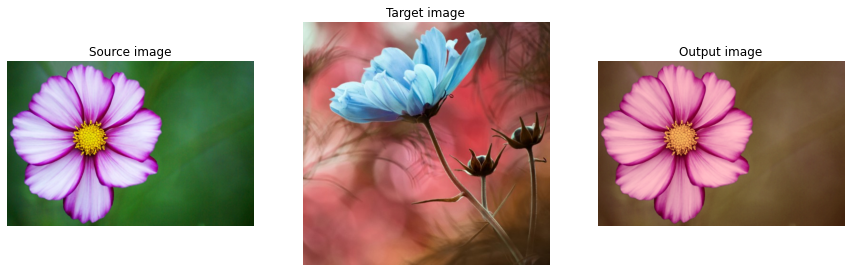

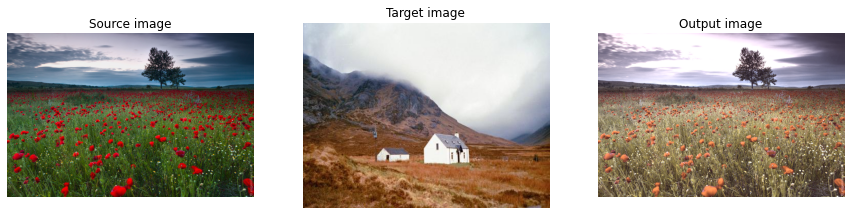

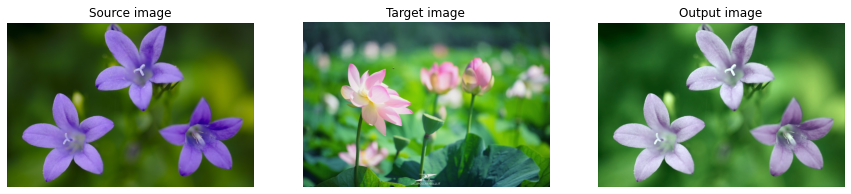

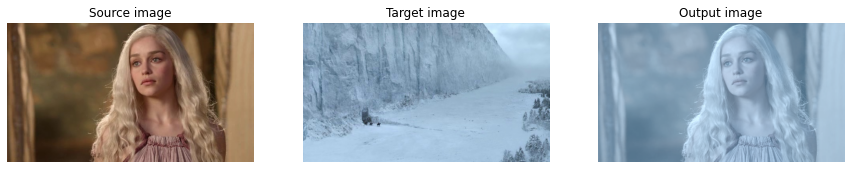

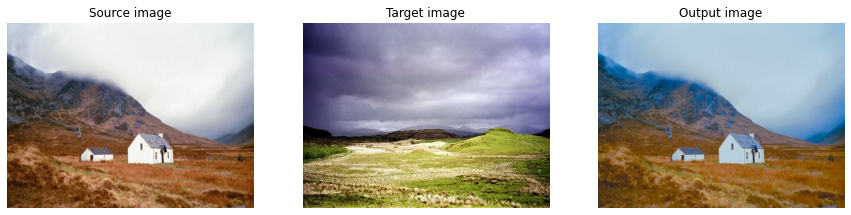

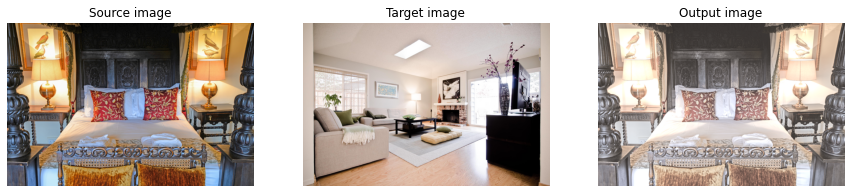

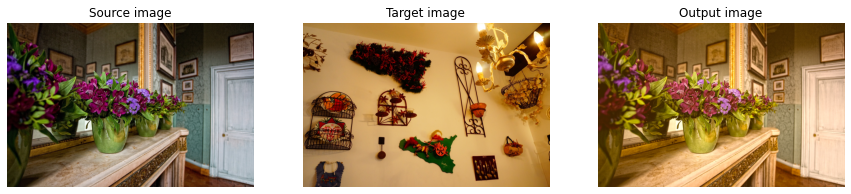

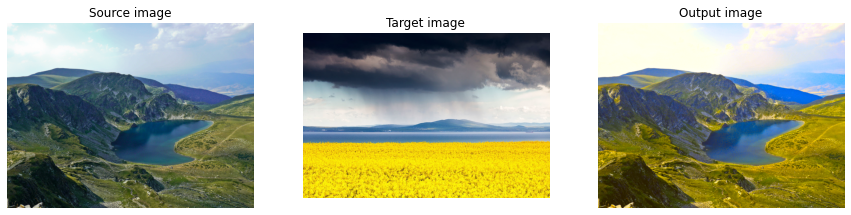

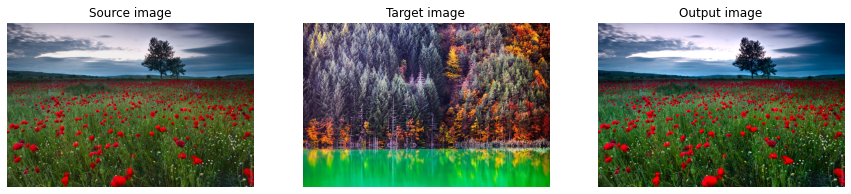

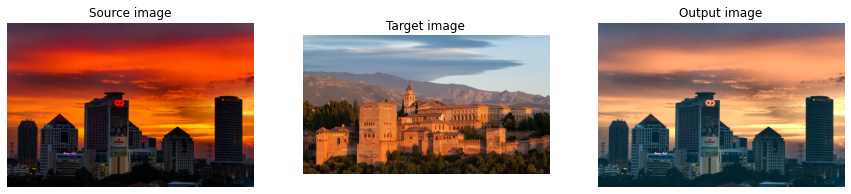

In [6]:
srcList = []
tarList = []
outList = []
for i in range(10):
    data_src, data_tar = read_file('ressources/img_input/' + str(i) + '_in.jpg', 'ressources/img_ref/' + str(i) +'_ref.jpg')
    srcList.append(data_src)
    tarList.append(data_tar)
    outList.append(colorTransfert(data_src, data_tar))
    show_imgs(data_src, data_tar, outList[-1])


# Appendix
Implementation of a histogram set allowing the spectral analysis of the source, reference and result images in the order in which the above images are displayed.

In [9]:
def show_1D_RGB_Histogram(data_src, data_tar, data_out=None, channel=-1):
    nbCols = 2
    
    data_hist_src = None
    data_hist_tar = None
    data_hist_out = None
    
    if data_out is not None:
        nbCols = 3

    fig, axes = plt.subplots(ncols=nbCols, figsize=(15, 5))
    ax = axes.ravel()
    ax[0] = plt.subplot(1, nbCols, 1)
    ax[1] = plt.subplot(1, nbCols, 2)
    
    if data_out is not None:
        ax[2] = plt.subplot(1, nbCols, 3)
    
    if channel != -1:
        colorParam = ''
        
        if channel == 0:
            colorParam = 'red'
        
        elif channel == 1:
            colorParam = 'green'

        elif channel == 2:
            colorParam = 'blue'

        data_hist_src = data_src[:, :, channel].ravel()
        data_hist_tar = data_tar[:, :, channel].ravel()
        
        ax[0].hist(data_hist_src, range=(0, 255), bins=255, color=colorParam)  
        ax[1].hist(data_hist_tar, range=(0, 255), bins=255, color=colorParam)
        
        if data_out is not None:
            data_hist_out = data_out[:, :, channel].ravel()
            ax[2].hist(data_hist_out, range=(0, 255), bins=255, color=colorParam)
        
        plt.xlabel(colorParam + ' value')
        plt.title('frequency of '+ colorParam + ' value')
    
    else:
        h_src, w_src, _ = data_src.shape
        h_tar, w_tar, _ = data_tar.shape
    
        data_hist_src = np.zeros((3, h_src * w_src), dtype=np.uint8)
        data_hist_tar = np.zeros((3, h_tar * w_tar), dtype=np.uint8)
            
        data_hist_src[0] = data_src[:, :, 0].ravel()
        data_hist_src[1] = data_src[:, :, 1].ravel()
        data_hist_src[2] = data_src[:, :, 2].ravel()

        data_hist_tar[0] = data_tar[:, :, 0].ravel()
        data_hist_tar[1] = data_tar[:, :, 1].ravel()
        data_hist_tar[2] = data_tar[:, :, 2].ravel()
        
        ax[0].hist(data_hist_src[0], range=(0, 255), bins=255, color='red')
        ax[0].hist(data_hist_src[1], range=(0, 255), bins=255, color='green')
        ax[0].hist(data_hist_src[2], range=(0, 255), bins=255, color='blue')
        
        ax[1].hist(data_hist_tar[0], range=(0, 255), bins=255, color='red')
        ax[1].hist(data_hist_tar[1], range=(0, 255), bins=255, color='green')
        ax[1].hist(data_hist_tar[2], range=(0, 255), bins=255, color='blue')
        
        
        if data_out is not None:
            h_out, w_out, _ = data_out.shape
            data_hist_out = np.zeros((3, h_out * w_out), dtype=np.uint8)
                
            data_hist_out[0] = data_out[:, :, 0].ravel()
            data_hist_out[1] = data_out[:, :, 1].ravel()
            data_hist_out[2] = data_out[:, :, 2].ravel()

            ax[2].hist(data_hist_out[0], range=(0, 255), bins=255, color='red')
            ax[2].hist(data_hist_out[1], range=(0, 255), bins=255, color='green')
            ax[2].hist(data_hist_out[2], range=(0, 255), bins=255, color='blue')
        
        plt.xlabel('RGB value')
        plt.title('frequency of superposed RGB values')

    ax[0].set_title('Source image histogram')
    ax[1].set_title('Target image histogram')
    if data_out is not None:
        ax[2].set_title('Output image Histogram')
    
    plt.ylabel('number of pixel')
    plt.show()

    return data_hist_src, data_hist_tar, data_hist_out

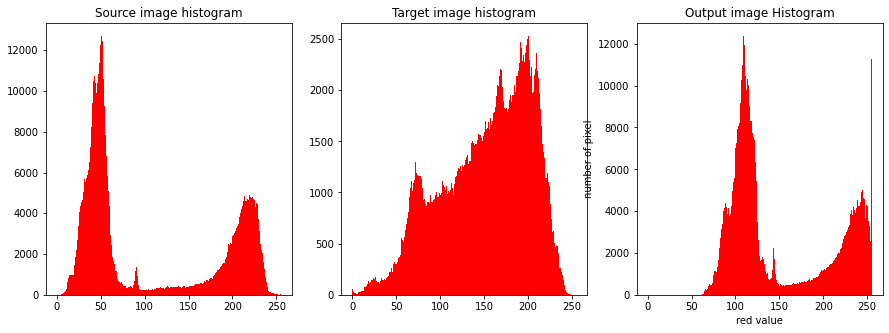

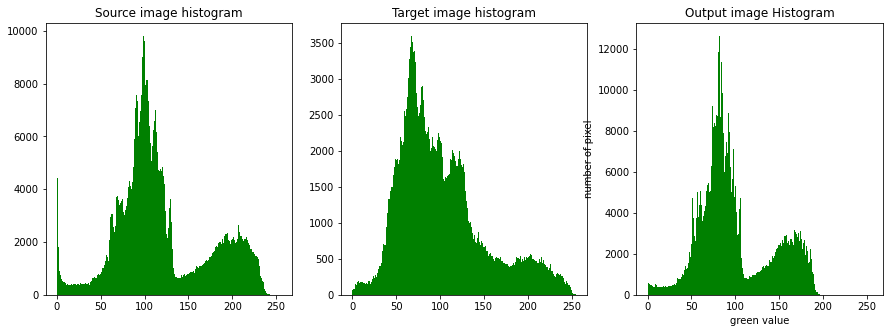

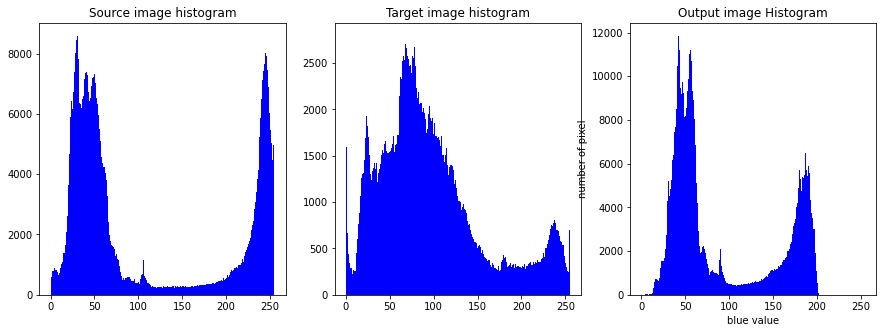

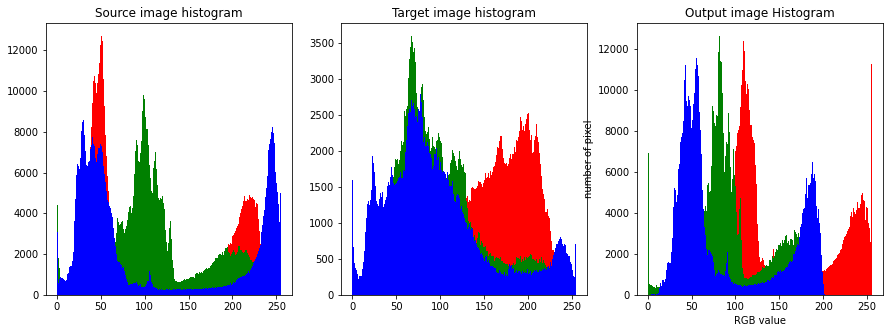

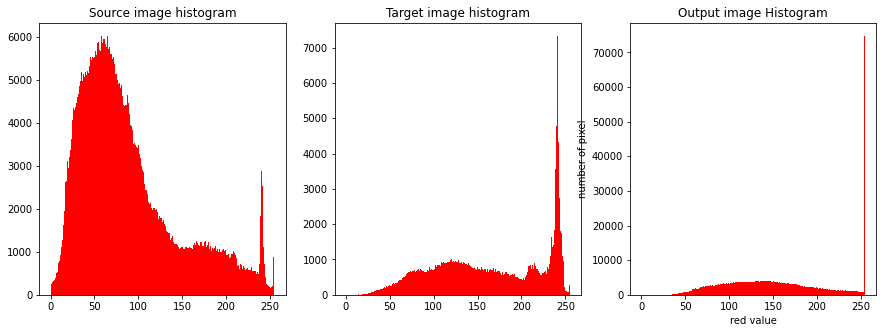

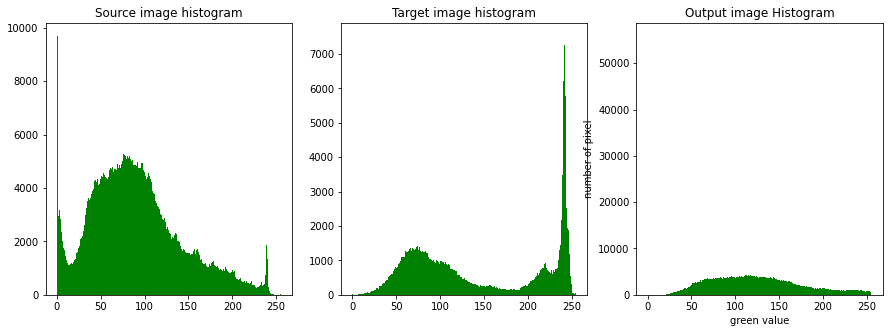

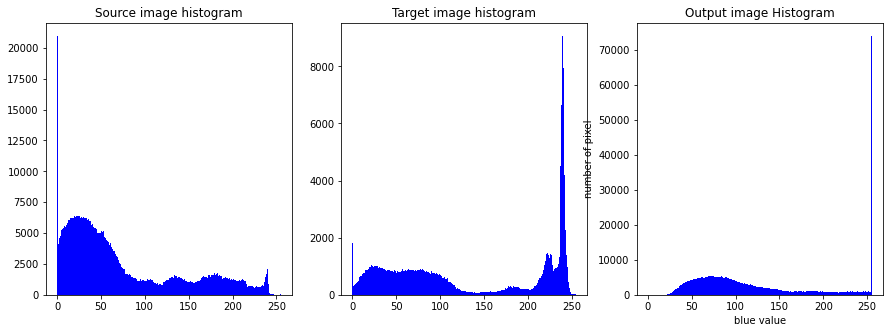

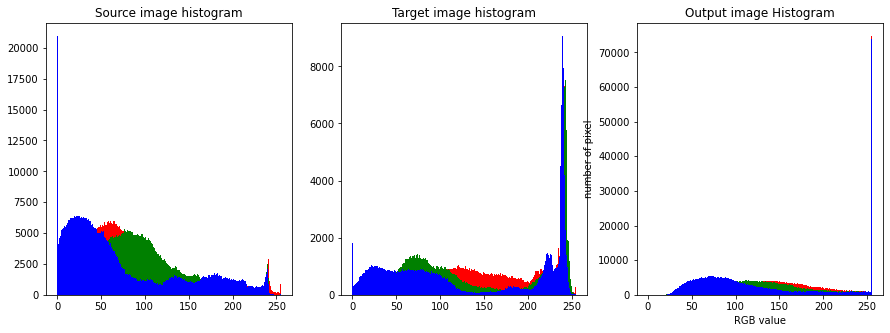

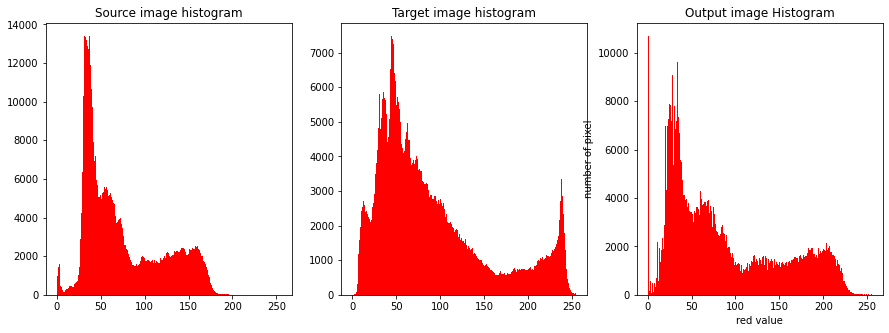

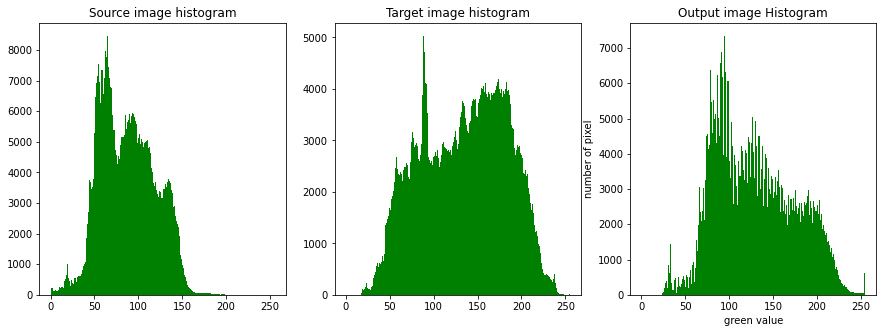

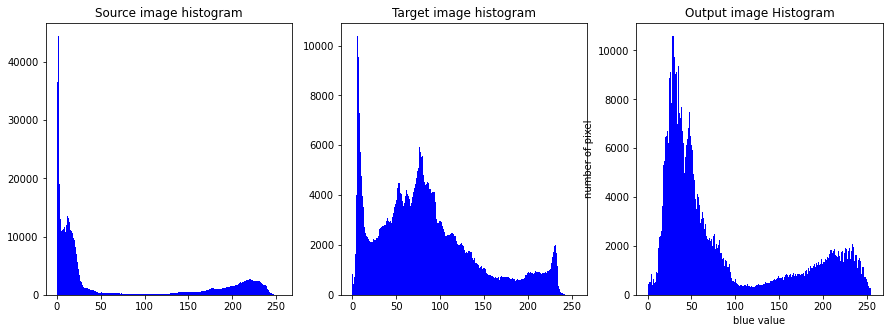

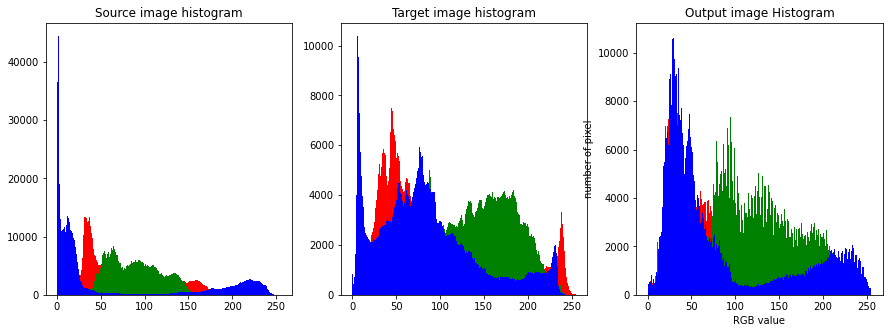

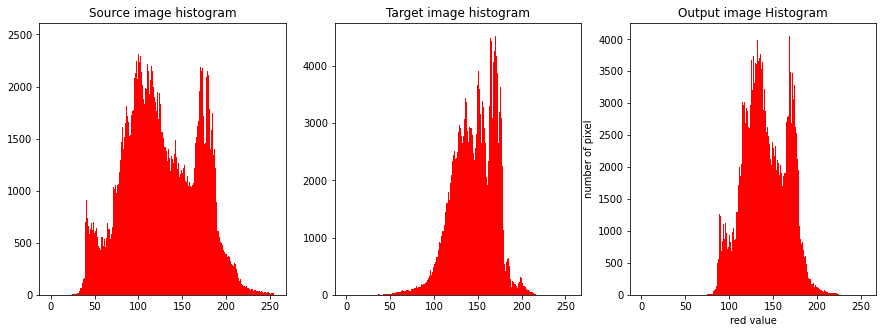

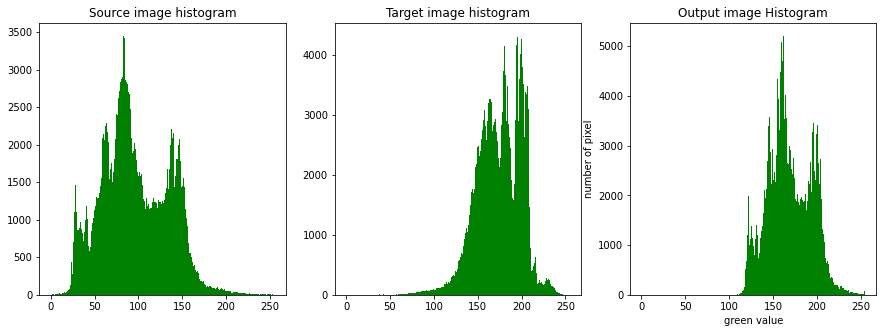

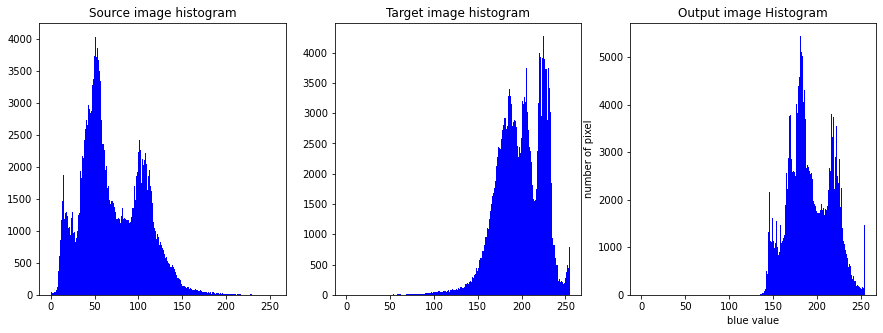

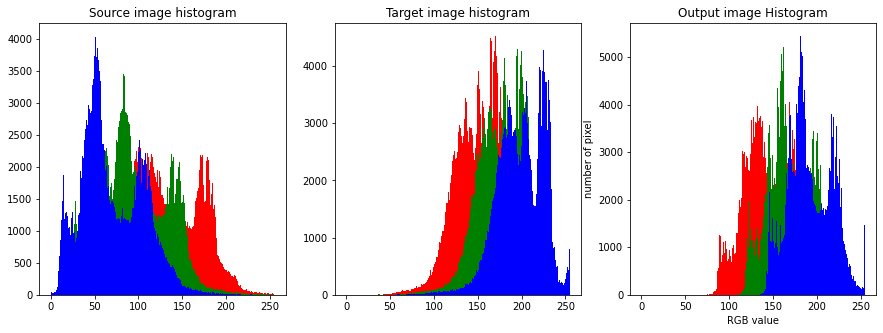

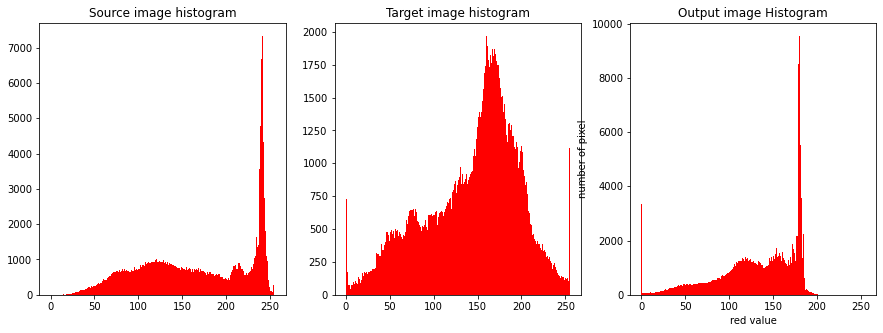

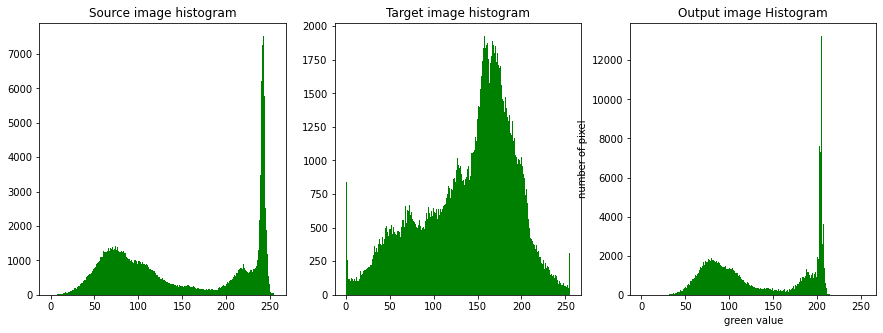

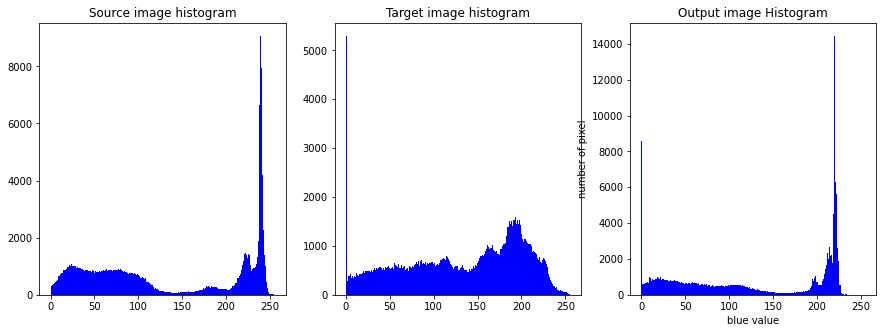

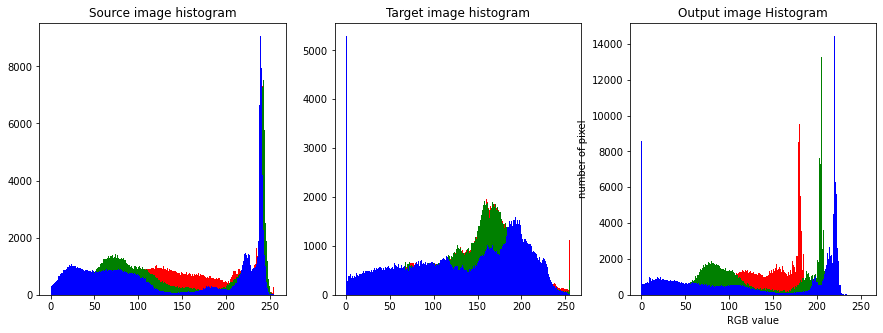

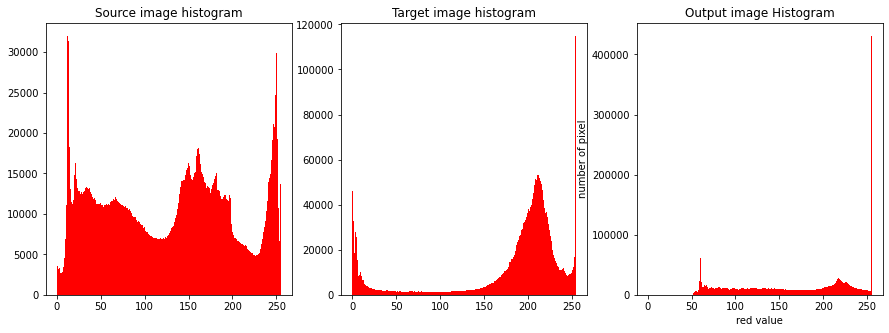

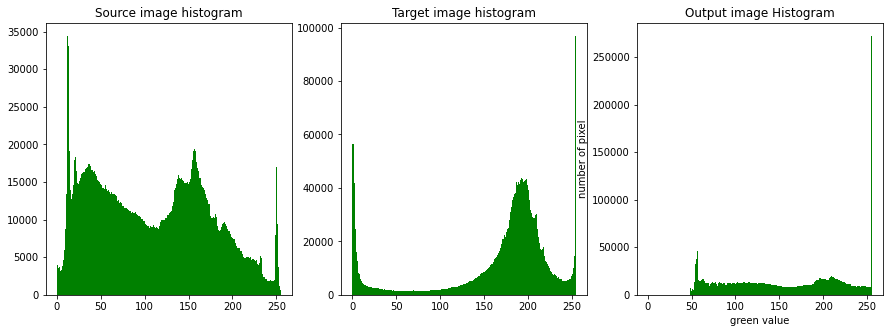

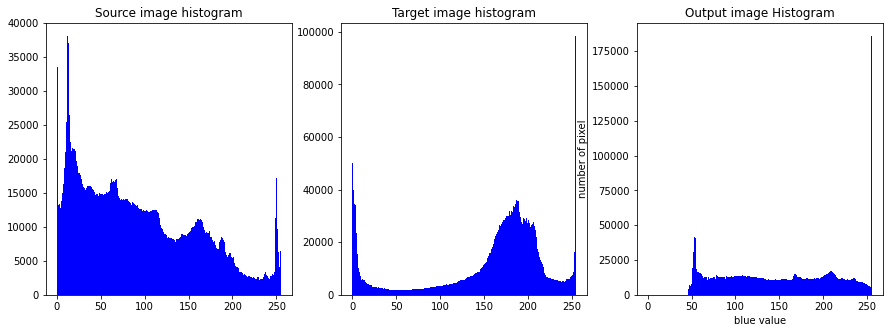

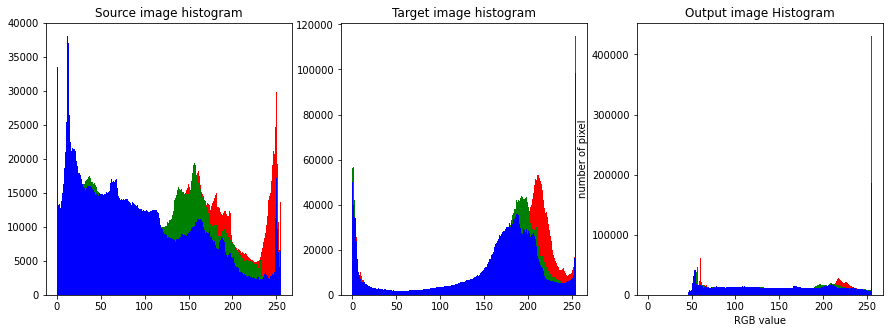

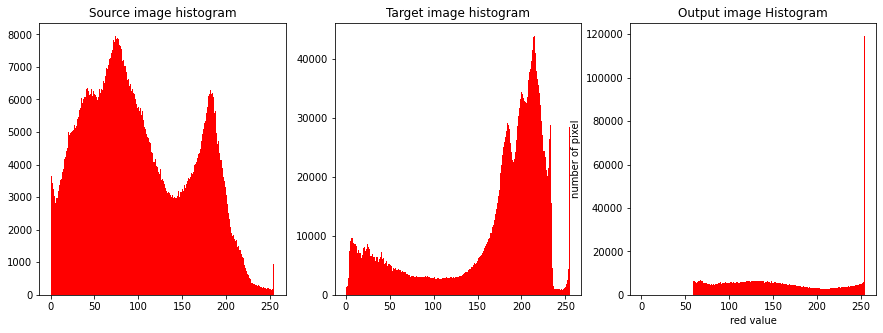

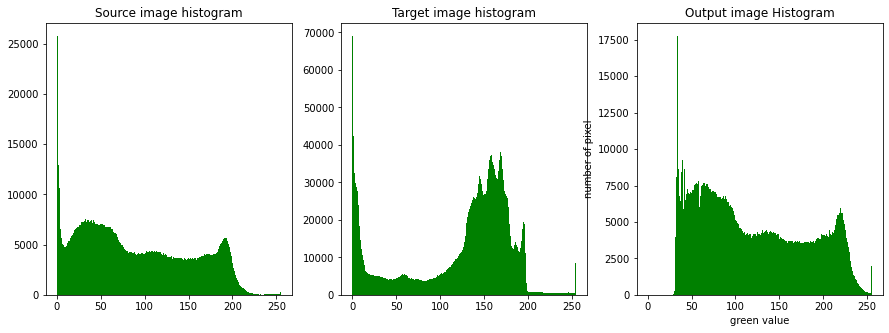

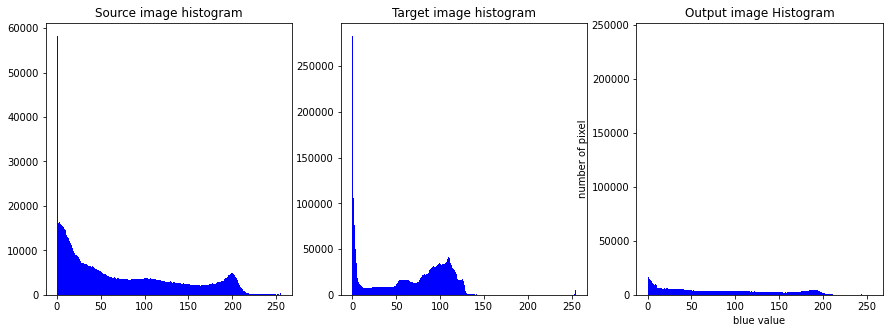

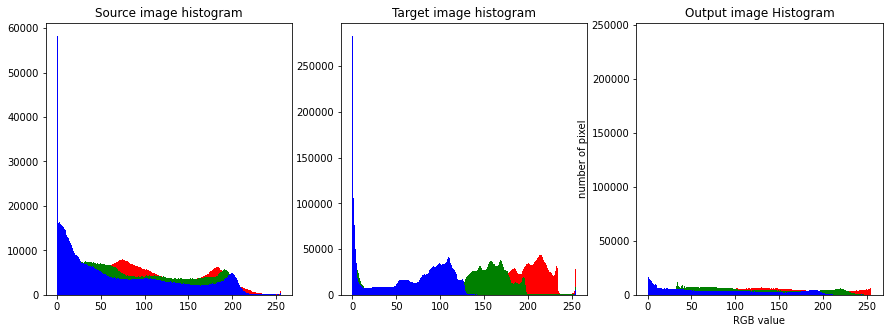

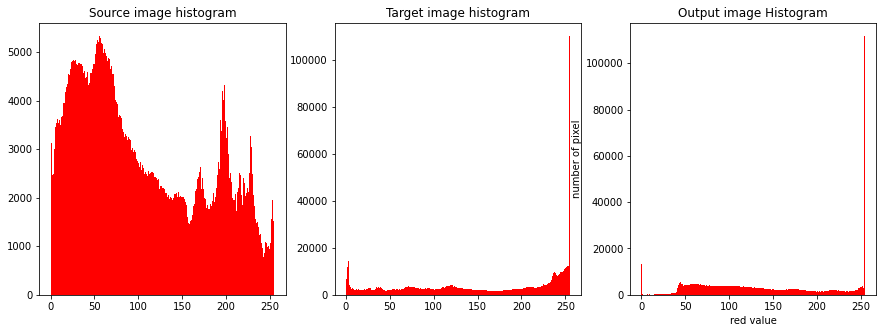

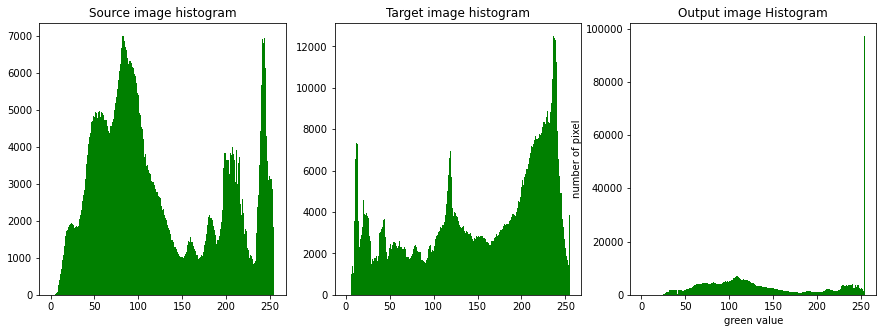

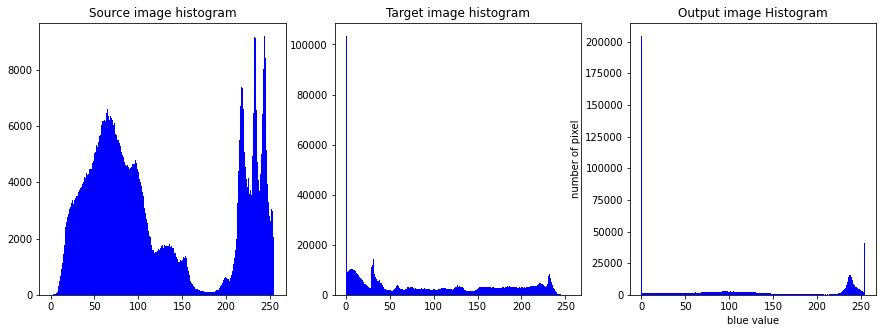

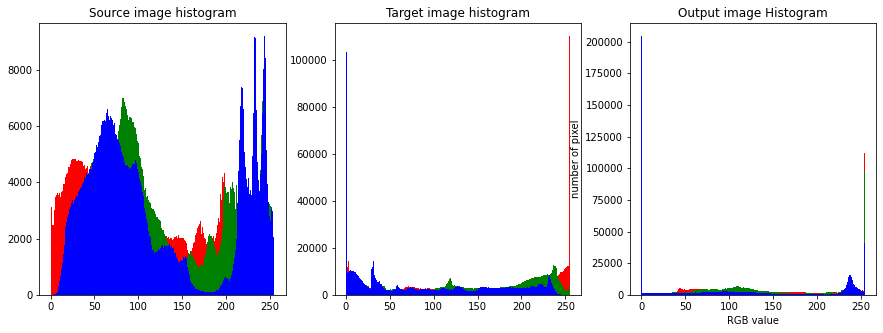

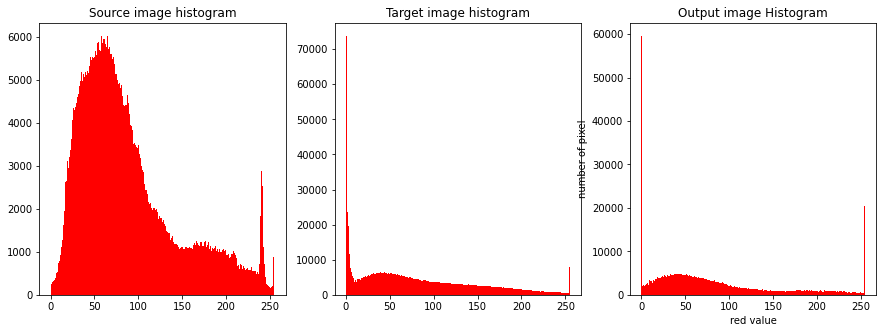

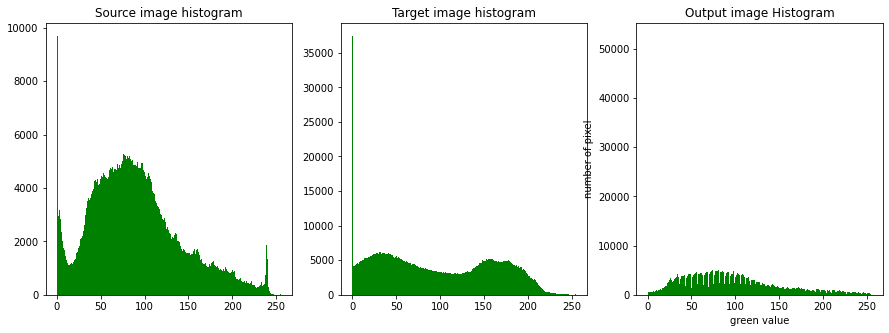

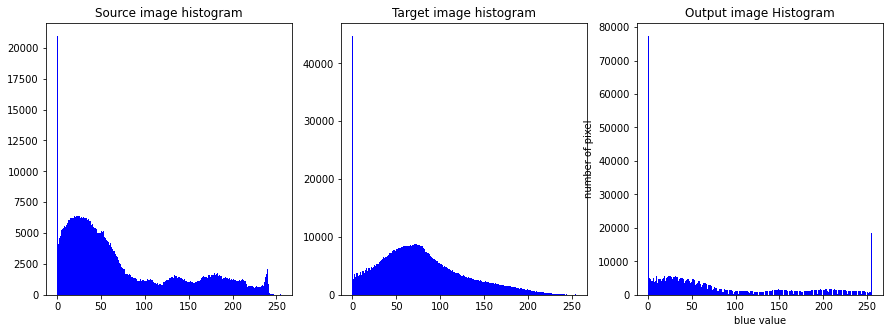

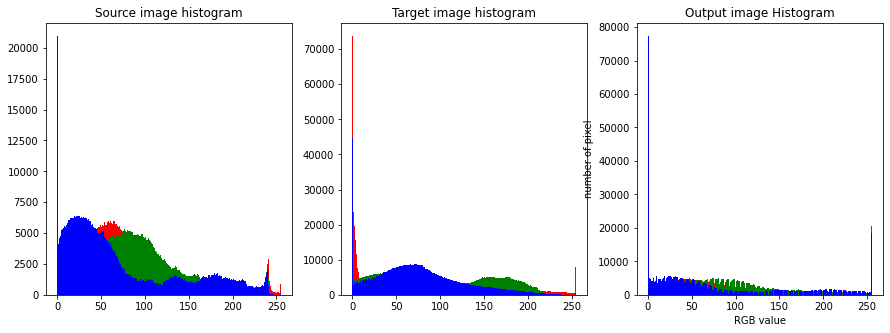

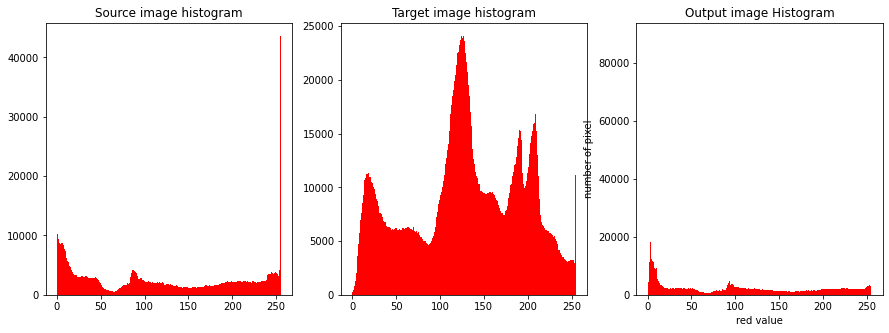

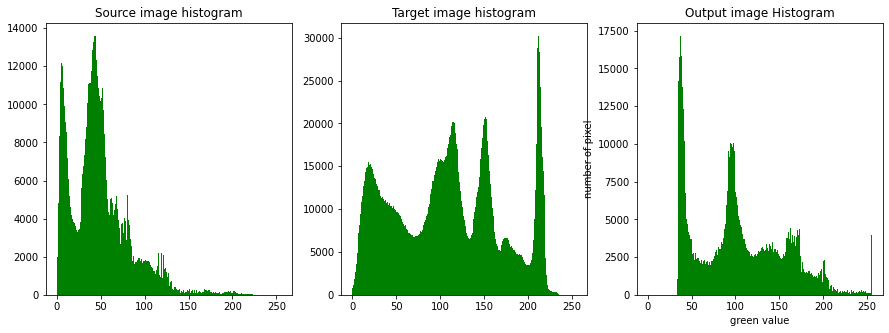

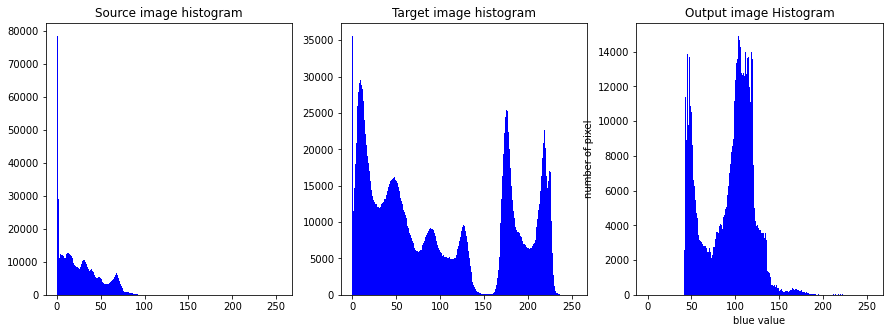

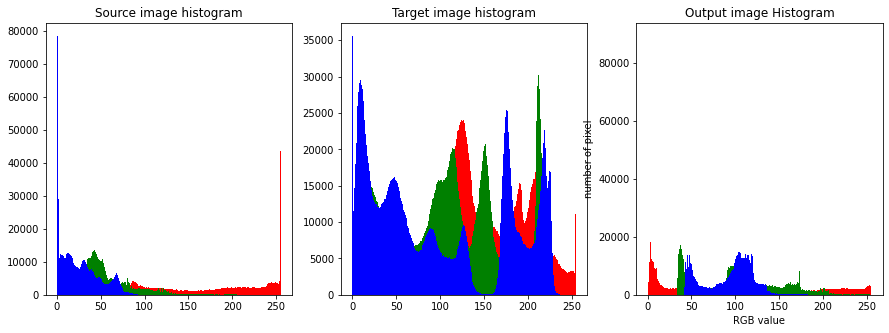

In [10]:
for i in range(10):
    show_1D_RGB_Histogram(srcList[i], tarList[i], outList[i], 0)
    show_1D_RGB_Histogram(srcList[i], tarList[i], outList[i], 1)
    show_1D_RGB_Histogram(srcList[i], tarList[i], outList[i], 2)

    show_1D_RGB_Histogram(srcList[i], tarList[i], outList[i])